In [1]:
import numpy as np
import pandas as pd
import random
import pickle as pkl
import networkx as nx
import scipy as sp
from scipy.spatial.distance import pdist,squareform
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
import seaborn as sns
from time import time
import copy
import math
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster

np.set_printoptions(linewidth=np.inf)
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',100)

In [2]:
# read data
def read_RS_data ():
    conditions=pd.read_csv('data/conditions0304.csv')
    demographics=pd.read_csv('data/demographics0304.csv')

    conditions=conditions[~conditions['ICD9CODX'].astype(str).str.startswith('-')]
    conditions=conditions[~conditions['ICD9CODX'].astype(str).str.startswith('V')]
    conditions=conditions[~conditions['ICD9CODX'].astype(str).str.startswith('E')]

    # make 2 tables (demographics and conditions) have the same patients
    inconsistent=list(set(demographics['DUPERSID'])-set(conditions['DUPERSID']))
    demographics=demographics[~demographics['DUPERSID'].isin(inconsistent)]

    # change name, we can merge conditions and demographics in the next step
    demographics=demographics.rename(columns={"Year":'year'})

    # divide table 'condition' into two parts (conditions_2003 and conditions_2004)
    conditions_2003=conditions[conditions['year']==2003].reset_index(drop=True)
    conditions_2004=conditions[conditions['year']==2004].reset_index(drop=True)

    conditions_2003_groupby=conditions_2003.groupby('DUPERSID')['ICD9CODX'].apply(list).to_frame()
    conditions_2003_groupby=conditions_2003_groupby.reset_index(drop=False)

    conditions_2004_groupby=conditions_2004.groupby('DUPERSID')['ICD9CODX'].apply(list).to_frame()
    conditions_2004_groupby=conditions_2004_groupby.reset_index(drop=False)

    # save string into dict
    dictString_2003 = {}
    userWithString_2003 = list(set(conditions_2003_groupby['DUPERSID'].values))
    for i in userWithString_2003:
            dictString_2003[i] = conditions_2003_groupby.loc[conditions_2003_groupby['DUPERSID'] == i, 'ICD9CODX'].item()

    # save string into dict
    dictString_2004 = {}
    userWithString_2004 = list(set(conditions_2004_groupby['DUPERSID'].values))
    for i in userWithString_2004:
            dictString_2004[i] = conditions_2004_groupby.loc[conditions_2004_groupby['DUPERSID'] == i, 'ICD9CODX'].item()

    all_patients = list(set(userWithString_2003+userWithString_2004))

    # change DOBYY in demographics
    for i, j in demographics.iterrows():
        if  2003 <= demographics.at[i, 'DOBYY'] <= 2004:
            demographics.at[i, 'DOBYY'] = 1 # infant
        if  1998 < demographics.at[i, 'DOBYY'] <= 2002:
            demographics.at[i, 'DOBYY'] = 2 # preschool
        if  1991 < demographics.at[i, 'DOBYY'] <= 1998:
            demographics.at[i, 'DOBYY'] = 3 # Child
        if  1985 < demographics.at[i, 'DOBYY'] <= 1991:
            demographics.at[i, 'DOBYY'] = 4 # Adolescent
        if  1959 < demographics.at[i, 'DOBYY'] <= 1985:
            demographics.at[i, 'DOBYY'] = 5 # Adult
        if  1939 < demographics.at[i, 'DOBYY'] <= 1959:
            demographics.at[i, 'DOBYY'] = 6 # Middle aged
        if  1924 < demographics.at[i, 'DOBYY'] <= 1939:
            demographics.at[i, 'DOBYY'] = 7 # Aged 
        if  1918 <= demographics.at[i, 'DOBYY'] <= 1924:
            demographics.at[i, 'DOBYY'] = 8 # 80 and over

    all_dictDemographics_2004={}
    for i in userWithString_2004:
        all_dictDemographics_2004[i] = demographics.loc[demographics['DUPERSID'] == i, ['DOBYY','SEX','RACEX']].values.tolist()[0]

    all_dictDemographics_Tolist_2004 = []
    for i in sorted(all_dictDemographics_2004.keys()):
        temp=[]
        for j in all_dictDemographics_2004[i]:
            temp.append(j)
        all_dictDemographics_Tolist_2004.append(temp)

    all_dictString_Tolist = []
    for i in sorted(dictString_2004.keys()):
        all_dictString_Tolist.append(dictString_2004[i])
        
    return all_dictDemographics_Tolist_2004, all_dictString_Tolist

## ICD-9 taxonomy

In [3]:
# get sub() for Weighted Edit Distance

In [4]:
def get_sub_cost():
    with open('data/ICD9hier.txt', 'r') as f:
        config = f.read().splitlines()
        icd_tree = []
        for ele in config:
            line = ele.split(' ')
            icd_tree.append(line)

    cutted_icd_tree = []
    for i in icd_tree:
        cutted_icd_tree.append(i[1:])

    icd_tree_inform = sorted([list(item) for item in set(tuple(row) for row in cutted_icd_tree)], key=lambda x: int(x[0]))

    for a,i in enumerate(icd_tree_inform):
        if len(i[0]) == 1:
            icd_tree_inform[a][0] = '00' + icd_tree_inform[a][0]
        if len(i[0]) == 2:
            icd_tree_inform[a][0] = '0' + icd_tree_inform[a][0]

    icd_DiGraph_inform = nx.DiGraph() 
    for i in icd_tree_inform:
        icd_DiGraph_inform.add_edges_from([(i[3],i[2]),(i[2],i[1]),(i[1],i[0])])

    def jc_distance_icd_tree (leaf_1,leaf_2):
        if leaf_1 == leaf_2:
            return 0
        else:
            closest_common_ascendant = list(nx.algorithms.tree_all_pairs_lowest_common_ancestor(icd_DiGraph_inform,root='001-999',  pairs=[(leaf_1, leaf_2)]))[0][1]
            number_of_leaves = len(nx.descendants(icd_DiGraph_inform, closest_common_ascendant))
            number_of_ascendants = len(nx.ancestors(icd_DiGraph_inform, closest_common_ascendant)) + 1

            jc_diatnce = 2 * math.log2((number_of_leaves/number_of_ascendants + 1) + 1)
            return jc_diatnce

    all_unique_icd = sorted(list(set([w for i in all_dictString_Tolist for w in i])))

    # compute cost of substitution for ICD code

    # jc_distance_icd_matrix = np.zeros([len(all_unique_icd),len(all_unique_icd)])
    # print('start to compute cost of substitution for ICD code')
    # print('please wait, this step may take a few mins')
    # t = time()

    # for a,i in enumerate(all_unique_icd):
    #     for b,j in enumerate(all_unique_icd):
    #         if (a != b and a < b ) : 
    #             jc_distance_icd_matrix[a][b] = 0
    #         else: 
    #             jc_distance_icd_matrix[a][b] = jc_distance_icd_matrix[b][a] = jc_distance_icd_tree(i,j)

    # print ("total run time for computing cost of substitution for ICD code :")
    # print (time()-t)

    #pkl.dump(jc_distance_icd_matrix,open('jc_distance_icd_matrix_informs.pkl','wb'),protocol = 4)

    # get substitution cost for icd codes
    with open ('data/jc_distance_icd_matrix_informs.pkl', 'rb') as fp:
        jc_distance_icd_matrix = pkl.load(fp)

    jc_distance_icd_matrix = jc_distance_icd_matrix / np.max(jc_distance_icd_matrix)
    
    return jc_distance_icd_matrix, all_unique_icd

## Get RS-Tree

In [5]:
def get_RS_tree():

    groups = [list(item) for item in set(tuple(row) for row in all_dictDemographics_Tolist_2004)]

    link = linkage(all_dictDemographics_Tolist_2004, method = 'average', metric='hamming')

    # plt.figure(figsize=(30,6))
    # plt.title('RS-tree for INFORMS')
    # plt.xlabel('The number of patients in each branch')
    # plt.ylabel('Hamming Distance')
    # dendrogram(
    #     link,
    #     truncate_mode='lastp',  # show only the last p merged clusters
    #     p=len(groups),  # show only the last p merged clusters
    #     #show_leaf_counts=False,  # otherwise numbers in brackets are counts
    #     leaf_rotation=45.,
    #     leaf_font_size=12. # to get a distribution impression in truncated branches
    # )
    # # plt.show()
    # plt.show()

    # tree for inform 2004
    RS_tree_edges_list = [(102,0),(103,1),(104,2),(105,3),(106,4),(107,5),(107,6),(109,7),(109,8),(111,9),(112,10),(112,11),(113,12)
                    ,(114,13),(115,14),(116,15),(117,16),(117,17),(121,18),(122,19),(122,20),(124,21),(125,22),(126,23),(127,24),(127,25)
                    ,(128,26),(129,27),(130,28),(131,29),(132,30),(132,31),(135,32),(136,33),(136,34),(138,35),(139,36),(139,37)
                    ,(140,38),(141,39),(142,40),(142,41),(144,42),(145,43),(146,44),(147,45),(148,46),(148,47),(149,48),(150,49),(151,50)
                    ,(152,51),(153,52),(153,53),(157,54),(158,55),(158,56),(159,57),(160,58),(161,59),(162,60),(162,61),(164,62),(164,63)
                    ,(165,64),(166,65),(166,66),(169,67),(170,68),(171,69),(172,70),(172,71),(173,72),(174,73),(175,74),(176,75),(177,76)
                    ,(177,77),(179,78),(180,79),(181,80),(182,81),(183,82),(183,83),(185,84),(186,85),(187,86),(188,87),(189,88),(189,89)
                    ,(190,90),(191,91),(192,92),(193,93),(193,94),(100,101),(100,118),(101,102),(101,108),(102,103),(103,104),(104,105),(105,106)
                    ,(106,107)
                    ,(108,109),(108,110),(110,111),(110,113),(111,112),(113,114),(114,115),(115,116),(116,117),(118,119),(118,154),(119,120)
                    ,(119,133),(120,121),(120,123),(121,122),(123,124),(123,128),(124,125),(125,126),(126,127),(128,129),(129,130),(130,131)
                    ,(131,132),(133,134),(133,143),(134,135),(134,137),(135,136),(137,138),(137,140),(138,139),(140,141),(141,142),(143,144)
                    ,(143,149),(144,145),(145,146),(146,147),(147,148),(149,150),(150,151),(151,152),(152,153),(154,155),(154,167),(155,156)
                    ,(155,163),(156,157),(156,159),(157,158),(159,160),(160,161),(161,162),(163,164),(163,165),(165,166),(167,168),(167,178)
                    ,(168,169),(168,173),(169,170),(170,171),(171,172),(173,174),(174,175),(175,176),(176,177),(178,179),(178,184),(179,180)
                    ,(180,181),(181,182),(182,183),(184,185),(184,190),(185,186),(186,187),(187,188),(188,189),(190,191),(191,192),(192,193)] 

    root_node = 100
    internal_nodes = list(range(100,194))
    max_leaves = len(all_dictDemographics_Tolist_2004)

    Graph_schema_directed = nx.DiGraph() 
    Graph_schema_directed.add_nodes_from(list(range(len(groups))))
    Graph_schema_directed.add_nodes_from(internal_nodes)
    Graph_schema_directed.add_edges_from(RS_tree_edges_list)

    kk = len(groups)
    cluser_modula = [[] for i in range(kk)]
    for a,i in enumerate(fcluster(link, kk, criterion='maxclust')):
        cluser_modula[i-1].append(a)

    demographics_tree_labels = fcluster(link, len(groups), criterion='maxclust')

    IC_internal_dict={}
    for a in internal_nodes:
        IC_internal_dict[a] = -math.log2(((sum([len(cluser_modula[j]) for j in [i for i in list(nx.descendants(Graph_schema_directed, a)) if i not in internal_nodes]])/(len(nx.ancestors(Graph_schema_directed, a))+1)) + 1)/(max_leaves+1))

    IC_internal_dict[root_node]=0

    tree_similarity_measure_matrix = np.zeros([len(groups),len(groups)])
    for a,i in enumerate(list(range(len(groups)))):
        for b,j in enumerate(list(range(len(groups)))):
            if (i != j and i <= len(groups) and j <= len(groups)):
                if nx.algorithms.lowest_common_ancestor(Graph_schema_directed, i, j) == None:
                    tree_similarity_measure_matrix[a][b] = tree_similarity_measure_matrix[b][a]= 100
                else:
                    tree_similarity_measure_matrix[a][b] = tree_similarity_measure_matrix[b][a]  = (-math.log2( (1) / (max_leaves+1) ) * 2) - (2 * IC_internal_dict[list(nx.algorithms.tree_all_pairs_lowest_common_ancestor(Graph_schema_directed,root=root_node,  pairs=[(i, j)]))[0][1]])

    normalization_for_tree = np.max(tree_similarity_measure_matrix)           
    tree_similarity_measure_matrix = tree_similarity_measure_matrix/ normalization_for_tree
    return demographics_tree_labels,tree_similarity_measure_matrix

## RS-Dataset k-Center (RSDC) Problem

In [6]:
class StringDistance:

    def distance(self, s0, s1):
        raise NotImplementedError()

from functools import reduce

def default_insertion_cost(char):
    return 1.0


def default_deletion_cost(char):
    return 1.0



def default_substitution_cost(char_a, char_b):
    return 1.0

class WeightedLevenshtein(StringDistance):

    def __init__(self,
                 substitution_cost_fn=default_substitution_cost,
                 insertion_cost_fn=default_insertion_cost,
                 deletion_cost_fn=default_deletion_cost,
                 ):
        self.substitution_cost_fn = substitution_cost_fn
        self.insertion_cost_fn = insertion_cost_fn
        self.deletion_cost_fn = deletion_cost_fn

    def distance(self, s0, s1):
        if s0 is None:
            raise TypeError("Argument s0 is NoneType.")
        if s1 is None:
            raise TypeError("Argument s1 is NoneType.")
        if s0 == s1:
            return 0.0
        if len(s0) == 0:
            return reduce(lambda cost, char: cost + self.insertion_cost_fn(char), s1, 0)
        if len(s1) == 0:
            return reduce(lambda cost, char: cost + self.deletion_cost_fn(char), s0, 0)

        v0, v1 = [0.0] * (len(s1) + 1), [0.0] * (len(s1) + 1)

        v0[0] = 0
        for i in range(1, len(v0)):
            v0[i] = v0[i - 1] + self.insertion_cost_fn(s1[i - 1])

        for i in range(len(s0)):
            s0i = s0[i]
            deletion_cost = self.deletion_cost_fn(s0i)
            v1[0] = v0[0] + deletion_cost

            for j in range(len(s1)):
                s1j = s1[j]
                cost = 0
                if s0i != s1j:
                    cost = self.substitution_cost_fn(s0i, s1j)
                insertion_cost = self.insertion_cost_fn(s1j)
                v1[j + 1] = min(v1[j] + insertion_cost, v0[j + 1] + deletion_cost, v0[j] + cost)
            v0, v1 = v1, v0

        return v0[len(s1)]

In [7]:
def insertion_cost(char):
    return 1.0


def deletion_cost(char):
    return 1.0


def substitution_cost(char_a, char_b):
    
    index_char_a = all_unique_icd.index(char_a)
    index_char_b = all_unique_icd.index(char_b)
    
    return jc_distance_icd_matrix[index_char_a][index_char_b]


weighted_levenshtein = WeightedLevenshtein(
    substitution_cost_fn=substitution_cost,
    insertion_cost_fn=insertion_cost,
    deletion_cost_fn=deletion_cost)

In [8]:
def kCenters(k,points_index):
    centers=[]
    random.shuffle(points_index) #Taking first random center
    centers.append(points_index.pop()) #Point removed so we don't loop between the two farthest points
    k-=1 
    distance_matrix = []
    distance_matrix.append(p_product_distance(centers[-1])) 
    while k>0: 
        k-=1
        centers.append(retFarthestPoint(centers, points_index, distance_matrix))
        distance_matrix.append(p_product_distance(centers[-1]))
    return centers,distance_matrix

def p_product_distance(selected_center):
    demographics_vector = [0] * n
    index_dem = demographics_tree_labels[selected_center]
    for a,i in enumerate(demographics_tree_labels):
        demographics_vector[a] = tree_similarity_measure_matrix[index_dem-1][i-1]
        
    icd_code_vector = [0] * n
    for i in range(n):
        icd_code_vector[i] = weighted_levenshtein.distance(all_dictString_Tolist[selected_center],all_dictString_Tolist[i])/max(len(all_dictString_Tolist[selected_center]),len(all_dictString_Tolist[i]))    
            
    p_product_vector = (w_dem * (np.array(demographics_vector) ** 2) + w_diag * (np.array(icd_code_vector) ** 2)) ** 0.5
    
    return list(p_product_vector)

def retFarthestPoint(all_centers,points_index,distance_matrix):
    distance_rows = copy.deepcopy(np.array(distance_matrix))
    min_values = np.amin(distance_rows, axis=0)
    indexes = np.concatenate(np.argwhere( min_values == np.max(min_values))).ravel().tolist()
    indexes_filtered = [x for x in indexes if x not in all_centers]
    index = random.choice(indexes_filtered)
    points_index.remove(index)
    return index

def get_cluster(points_index,centers,distance_matrix):
    index_cluster = np.argmin(np.array(distance_matrix), axis=0)
    all_clusters = [[] for i in centers]
    for a,i in enumerate(index_cluster):
        all_clusters[i].append(a)
    return all_clusters

In [9]:
if __name__ == '__main__':
    all_dictDemographics_Tolist_2004, all_dictString_Tolist = read_RS_data()
    jc_distance_icd_matrix, all_unique_icd = get_sub_cost()
    demographics_tree_labels, tree_similarity_measure_matrix = get_RS_tree()
    n = len(all_dictDemographics_Tolist_2004)
    k = 50
    w_dem = 0.5 
    w_diag = 0.5 
    t = time()
    points_index = list(range(n))
    centers,distance_matrix_kCenters = kCenters(k,points_index)
    final_clusters = get_cluster(points_index,centers,distance_matrix_kCenters)
    print ("total run time:")
    print (time()-t)

total run time:
143.9026963710785


## ASPJ and ASPWE 

In [ ]:
# this takes many time
weighted_edit = np.zeros([n,n])

for i in range(n):
    for j in range(n):
        if (i != j and i < j):
            weighted_edit[i][j] = weighted_edit[j][i] = weighted_levenshtein.distance(all_dictString_Tolist[i],all_dictString_Tolist[j])/max(len(all_dictString_Tolist[i]),len(all_dictString_Tolist[j])) 

In [11]:
# with open ('medical data/weighted_edit_inform_2004.pkl', 'rb') as fp:
#     weighted_edit_inform_2004 = pkl.load(fp)
    
Demog_jaccard = pdist(all_dictDemographics_Tolist_2004, metric='jaccard')

In [12]:
def get_ASPJ_and_ASPWE(distance,labels):
    sum_ASPJ_and_ASPWE_for_clusetrs = []
    for i in labels:
         sum_ASPJ_and_ASPWE_for_clusetrs.append(np.sum(distance[np.ix_(i,i)])/2)
    return np.mean(sum_ASPJ_and_ASPWE_for_clusetrs)

In [ ]:
print (f'ASPWE: = {get_ASPJ_and_ASPWE(weighted_edit,final_clusters):.3f}')

In [24]:
#print (f'ASPWE: = {get_ASPJ_and_ASPWE(weighted_edit_inform_2004,final_clusters):.3f}')

In [13]:
print (f'ASPJ: = {get_ASPJ_and_ASPWE(squareform(Demog_jaccard),final_clusters):.3f}')

ASPJ: = 43627.280


## Heat maps

In [31]:
# 'Age','Gender','RACE'
heat_map_AGE = np.zeros([k,8])
heat_map_GENDER = np.zeros([k,2])
heat_map_ETHNICITY = np.zeros([k,6])

In [32]:
for index,cluster in enumerate(final_clusters):
    for patient in cluster:
        if all_dictDemographics_Tolist_2004[patient][0] == 1:
            heat_map_AGE[index][0] += 1
        if all_dictDemographics_Tolist_2004[patient][0] == 2:
            heat_map_AGE[index][1] += 1        
        if all_dictDemographics_Tolist_2004[patient][0] == 3:
            heat_map_AGE[index][2] += 1
        if all_dictDemographics_Tolist_2004[patient][0] == 4:
            heat_map_AGE[index][3] += 1            
        if all_dictDemographics_Tolist_2004[patient][0] == 5:
            heat_map_AGE[index][4] += 1            
        if all_dictDemographics_Tolist_2004[patient][0] == 6:
            heat_map_AGE[index][5] += 1    
        if all_dictDemographics_Tolist_2004[patient][0] == 7:
            heat_map_AGE[index][6] += 1       
        if all_dictDemographics_Tolist_2004[patient][0] == 8:
            heat_map_AGE[index][7] += 1            

In [33]:
heat_map_AGE_sum = heat_map_AGE.sum(axis=1)
for a,i in enumerate(heat_map_AGE):
    heat_map_AGE[a] = i / heat_map_AGE_sum[a]

In [34]:
for index,cluster in enumerate(final_clusters):
    for patient in cluster:
        if all_dictDemographics_Tolist_2004[patient][1] == 1:
            heat_map_GENDER[index][0] += 1
        if all_dictDemographics_Tolist_2004[patient][1] == 2:
            heat_map_GENDER[index][1] += 1             

In [35]:
heat_map_GENDER_sum = heat_map_GENDER.sum(axis=1)
for a,i in enumerate(heat_map_GENDER):
    heat_map_GENDER[a] = i / heat_map_GENDER_sum[a]

In [36]:
for index,cluster in enumerate(final_clusters):
    for patient in cluster:
        if all_dictDemographics_Tolist_2004[patient][2] == 1:
            heat_map_ETHNICITY[index][0] += 1
        if all_dictDemographics_Tolist_2004[patient][2] == 2:
            heat_map_ETHNICITY[index][1] += 1        
        if all_dictDemographics_Tolist_2004[patient][2] == 3:
            heat_map_ETHNICITY[index][2] += 1
        if all_dictDemographics_Tolist_2004[patient][2] == 4:
            heat_map_ETHNICITY[index][3] += 1            
        if all_dictDemographics_Tolist_2004[patient][2] == 5:
            heat_map_ETHNICITY[index][4] += 1            
        if all_dictDemographics_Tolist_2004[patient][2] == 6:
            heat_map_ETHNICITY[index][5] += 1    

In [37]:
heat_map_ETHNICITY_sum = heat_map_ETHNICITY.sum(axis=1)
for a,i in enumerate(heat_map_ETHNICITY):
    heat_map_ETHNICITY[a] = i / heat_map_ETHNICITY_sum[a]

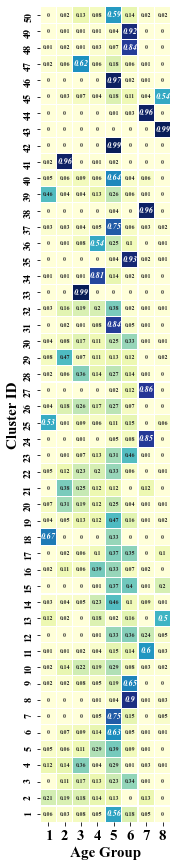

In [38]:
plt.figure(3,figsize=(15,15))
plt.rc('font', family='serif', serif='Times New Roman', weight='bold')
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=15,linewidth=1)

x_axis_labels = [1,2,3,4,5,6,7,8]
y_axis_labels = list(range(1,k+1))[::-1]
ax = sns.heatmap(np.round(heat_map_AGE,2), cmap="YlGnBu",square = True,annot=True,fmt=".2g",annot_kws={"fontsize":7},
                 cbar=False,cbar_kws={"shrink": .5},linewidths=.1,xticklabels=x_axis_labels, yticklabels =y_axis_labels)


plt.ylabel('Cluster ID',fontweight='bold')
plt.xlabel('Age Group',fontweight='bold')

for text in ax.texts:
    text.set_size(6)
    if float(text.get_text()) >= 0.5:
        text.set_size(8.5)
        text.set_weight('bold')
        text.set_style('italic')
#plt.xlim(19,201) 
#plt.xticks(np.arange(20, 220, step=20))
#plt.yscale('log')
#plt.ylim(0,60) 
#plt.yticks([5,20,30])
#plt.show()
plt.show()

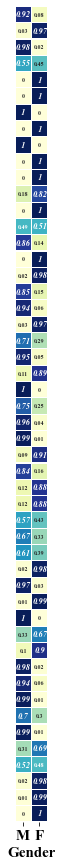

In [39]:
plt.figure(3,figsize=(15,15))
plt.rc('font', family='serif', serif='Times New Roman', weight='bold')
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=15,linewidth=1)
#plt.ylabel('ASPJ',fontweight='bold')
#plt.xlabel('weight on hamming distance',fontweight='bold')
x_axis_labels = ['M','F']
ax = sns.heatmap(np.round(heat_map_GENDER,2), cmap="YlGnBu",square = True,annot=True,fmt=".2g",annot_kws={"fontsize":7},
                 cbar=False,cbar_kws={"shrink": .5},linewidths=.1,xticklabels=x_axis_labels)
plt.xlabel('Gender',fontweight='bold')
for text in ax.texts:
    text.set_size(6)
    if float(text.get_text()) >= 0.5:
        text.set_size(8.5)
        text.set_weight('bold')
        text.set_style('italic')
#plt.xlim(19,201) 
#plt.xticks(np.arange(20, 220, step=20))
#plt.yscale('log')
#plt.ylim(0,60) 
plt.yticks([])
#plt.yticks([5,20,30])
#plt.show()
plt.show()

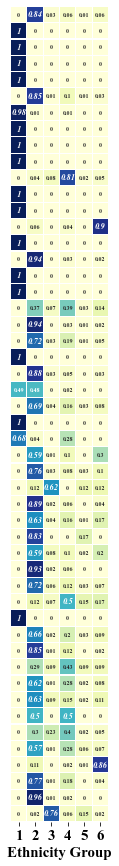

In [40]:
plt.figure(3,figsize=(15,15))
plt.rc('font', family='serif', serif='Times New Roman', weight='bold')
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=15,linewidth=1)
#plt.ylabel('ASPJ',fontweight='bold')
#plt.xlabel('weight on hamming distance',fontweight='bold')
x_axis_labels= [1,2,3,4,5,6]
ax = sns.heatmap(np.round(heat_map_ETHNICITY,2), cmap="YlGnBu",square = True,annot=True,fmt=".2g",annot_kws={"fontsize":7},
                 cbar=False,cbar_kws={"shrink": .3},linewidths=.1,xticklabels=x_axis_labels)
plt.xlabel('Ethnicity Group',fontweight='bold')
for text in ax.texts:
    text.set_size(6)
    if float(text.get_text()) >= 0.5:
        text.set_size(8.5)
        text.set_weight('bold')
        text.set_style('italic')
#plt.xlim(19,201) 
#plt.xticks(np.arange(20, 220, step=20))
#plt.yscale('log')
#plt.ylim(0,60) 
plt.yticks([])
#plt.show()
#plt.yticks([5,20,30])
plt.show()

In [41]:
heat_map_Diseases = np.zeros([k,17])
for a,i in enumerate(final_clusters):
    for b,group in enumerate([range(1,140),range(140,240),range(240,280),range(280,290),range(290,320),
                              range(320,390),range(390,460),range(460,520)
                     ,range(520,580),range(580,630),range(630,680),range(680,710),range(710,740),
                              range(740,760),range(760,780),range(780,800)
                     ,range(800,1000)]):
        count = 0
        for j in i:
            for w in all_dictString_Tolist[j]:
                if int(w) in list(group):
                    count +=1
                    break
            heat_map_Diseases[a][b] = count

In [42]:
heat_map_Diseases_sum = [len([all_dictString_Tolist[a] for a in final_clusters[i]]) for i in range(k)]
for a,i in enumerate(heat_map_Diseases):
    heat_map_Diseases[a] = i / heat_map_Diseases_sum[a]

In [43]:
top_k_list=[]
for a, i in enumerate(heat_map_Diseases):
    top_k_list.append(sorted(i,reverse=True)[1])

In [44]:
for a,i in enumerate(heat_map_Diseases):
    for b,j in enumerate(i):
        if heat_map_Diseases[a][b] < top_k_list[a]:
            heat_map_Diseases[a][b] = 0

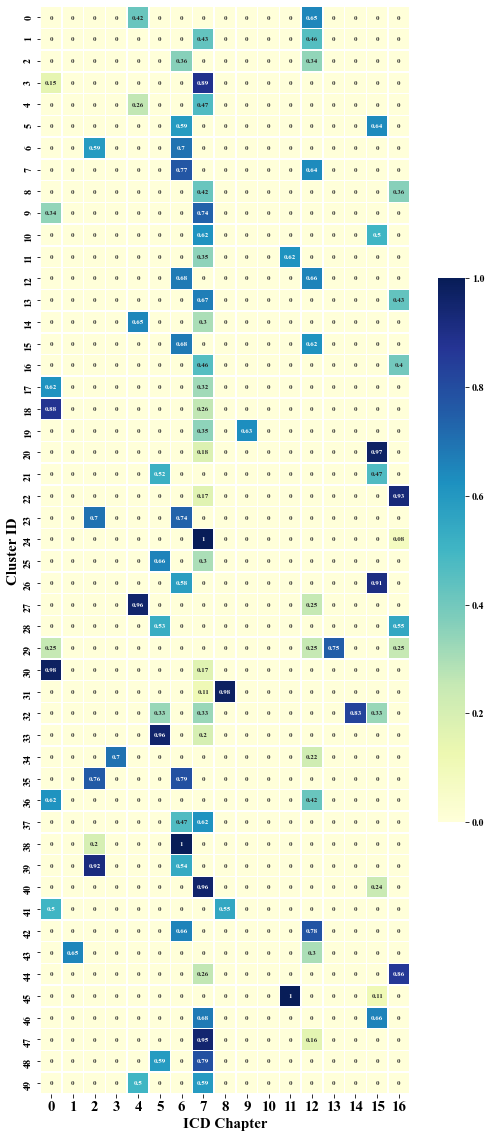

In [45]:
plt.figure(3,figsize=(10,20))
plt.rc('font', family='serif', serif='Times New Roman', weight='bold')
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=15,linewidth=1)
ax = sns.heatmap(np.round(heat_map_Diseases,2), cmap="YlGnBu",square = True,annot=True,fmt=".2g",annot_kws={"fontsize":7},cbar=True,cbar_kws={"shrink": .5},linewidths=.5)
plt.ylabel('Cluster ID',fontweight='bold')
plt.xlabel('ICD Chapter',fontweight='bold')

# for text in ax.texts:
#     text.set_size(6)
#     if float(text.get_text()) >= 0.5:
#         text.set_size(8.5)
#         text.set_weight('bold')
#         text.set_style('italic')
#plt.xlim(19,201) 
#plt.xticks(np.arange(20, 220, step=20))
#plt.yscale('log')
#plt.ylim(0,60) 
#plt.yticks([5,20,30])
plt.show()